# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

## Sources

In [35]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [44]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.3, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(5E46 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(5e-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(1E5 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.43, Emin, Emax)
my_sources = Sources()
my_sources.add(point_source)
my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 

my_sources.add_atmospheric_component() # auto atmo component

In [45]:
my_sources.associated_fraction()

<Quantity 0.05305342>

## Simulation

In [46]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [47]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


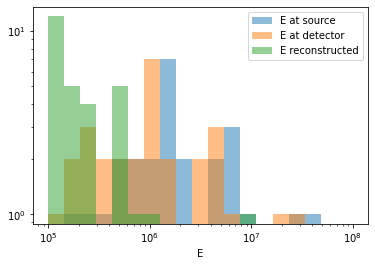

In [48]:
fig, ax = sim.show_spectrum()

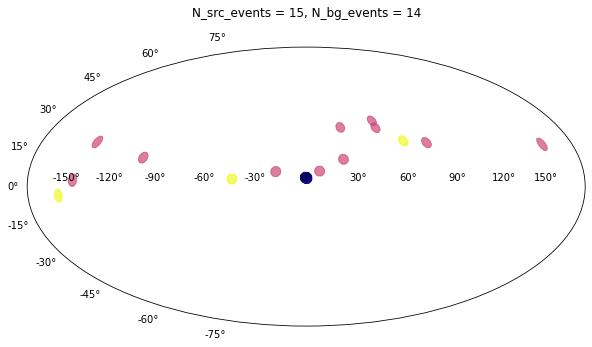

In [49]:
fig, ax = sim.show_skymap()

## Fit 

In [52]:
from python.events import Events
from python.fit import StanFit
from python.detector_model import NorthernTracksDetectorModel

In [53]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [54]:
fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
fit.setup_and_run(show_progress=True)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
Chain 1 -   done: 100%|██████████| 2000/2000 [05:14<00:00,  6.36it/s]


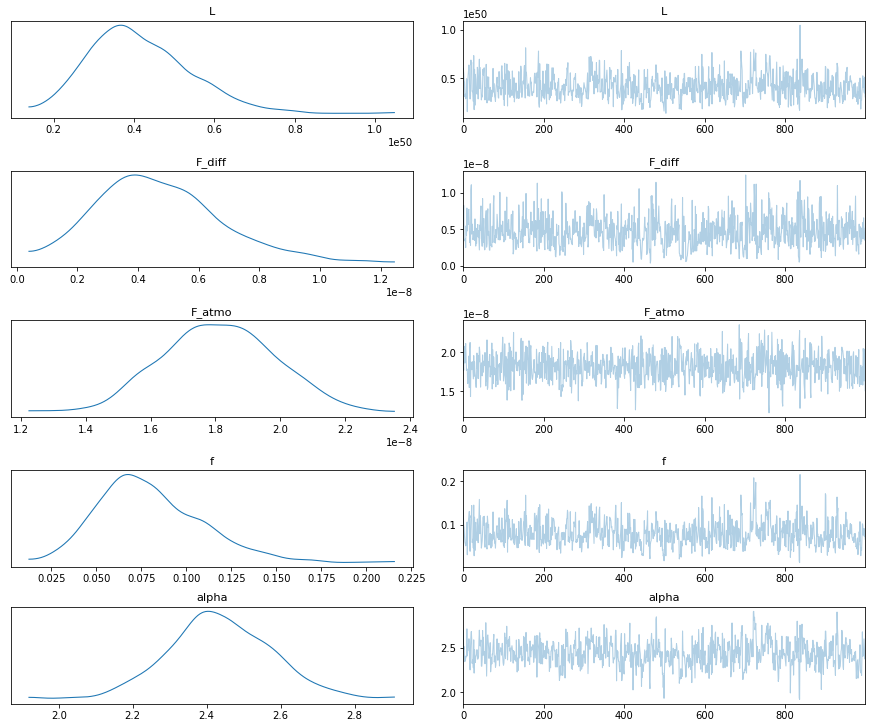

In [55]:
fit.plot_trace(var_names=["L", "F_diff", "F_atmo", "f", "alpha"])

In [56]:
fit.save("output/test_fit_file.h5")

We can check the results of the fit against the known true values from the above simulation.

In [57]:
from python.simulation import SimInfo

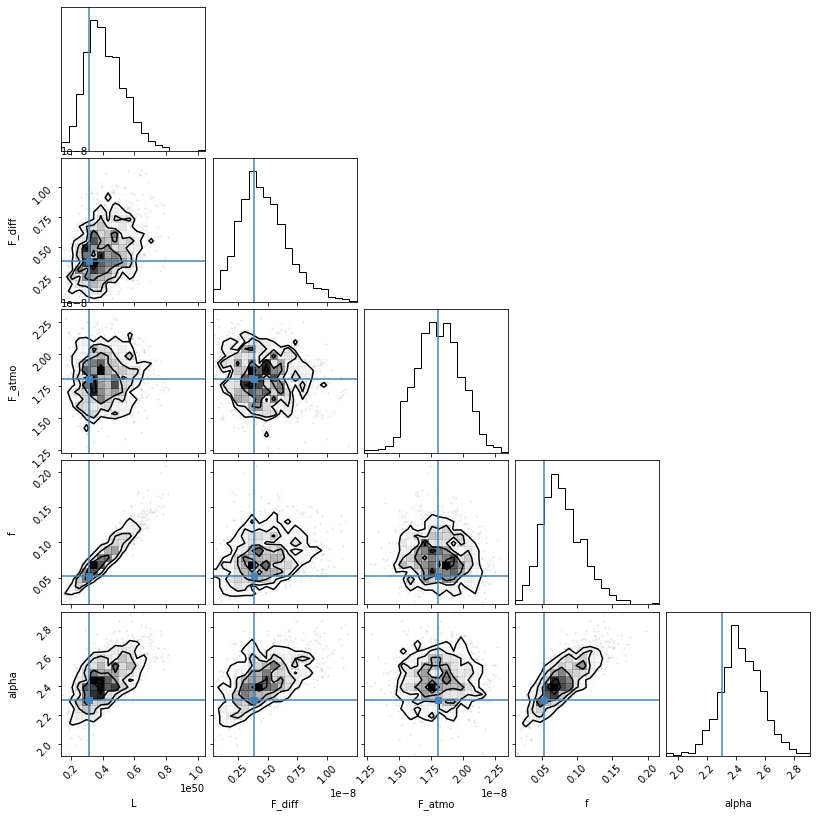

In [58]:
sim_info = SimInfo.from_file("output/test_sim_file.h5")
fig = fit.corner_plot(truths=sim_info.truths)

Similarly, we can use the simulation info to check the classification of individual events. We shouldn't be concerned if things are slighty off, particularly between the two background components. 

In [59]:
fit.check_classification(sim_info.outputs)

Event 2 is misclassified
P(src0) = 0.000000
P(diff) = 0.303061
P(atmo) = 0.696939
The correct component is diff
Event 9 is misclassified
P(src0) = 0.000000
P(diff) = 0.478547
P(atmo) = 0.521453
The correct component is diff
Event 13 is misclassified
P(src0) = 0.000000
P(diff) = 0.383208
P(atmo) = 0.616792
The correct component is diff
Event 16 is misclassified
P(src0) = 0.000000
P(diff) = 0.273244
P(atmo) = 0.726756
The correct component is diff
Event 18 is misclassified
P(src0) = 0.000000
P(diff) = 0.338442
P(atmo) = 0.661558
The correct component is diff
Event 19 is misclassified
P(src0) = 0.000000
P(diff) = 0.496330
P(atmo) = 0.503670
The correct component is diff
Event 25 is misclassified
P(src0) = 0.000000
P(diff) = 0.497944
P(atmo) = 0.502056
The correct component is diff
A total of 7 events out of 29 are misclassified


## Debug

In [60]:
from matplotlib import pyplot as plt
from python.model_check import ModelCheck

In [61]:
model_check = ModelCheck()

In [63]:
#file_stem = "simulation_study/output/output/"
#file_list = [file_stem+"fit_sim_numu_1000.h5", file_stem+"fit_sim_numu_9900.h5"]
model_check.load(["simulation_study/output/fit_sim_numu_1000.h5"])

In [64]:
model_check.truths

{'F_atmo': 1.8071375858713813e-08,
 'F_diff': 1.1075528574928475e-09,
 'L': 1e+47,
 'alpha': 2.3,
 'f': 0.11351354619174933}

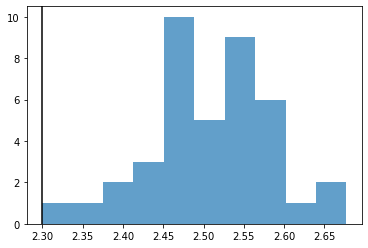

In [77]:
key = "alpha"
fig, ax = plt.subplots()
ax.hist(model_check.results[key], alpha=0.7)
ax.axvline(model_check.truths[key], color='k')